In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/Users/zhouji/Documents/github/gempy")

from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import pandas as pd
import gempy as gp
from gempy.assets.geophysics import GravityPreprocessing

def Plot_2D_scaler_field(grid,scaler_field):
    G = grid[np.where(grid[:,1] == [grid[-1][1]])[0]]
    S = scaler_field.numpy()[np.where(grid[:,1] == [grid[0][1]])[0]]
    XX = G[:,0].reshape([50,50])
    ZZ = G[:,2].reshape([50,50])
    S = S.reshape([50,50])
    plt.contour(XX,ZZ,S)


geo_data = gp.create_data([0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_orientations.csv",
                          path_i="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_surface_points.csv")
gp.map_series_to_surfaces(geo_data, {"Strat_Series": (
    'rock2', 'rock1'), "Basement_Series": ('basement')})

geo_data.add_surface_values([2.61,3.1,2.92])

## Gravity test
## ---------
grav_res = 20
X = np.linspace(0, 1000, grav_res)
Y = np.linspace(0, 1000, grav_res)
Z= 300
xyz= np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T


geo_data.set_centered_grid(xy_ravel,  resolution = [10, 10, 15], radius=5000)
interpolator = geo_data.interpolator
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']

dips_position, dip_angles, azimuth, polarity, surface_points_coord, fault_drift, grid, values_properties = interpolator.get_python_input_block()[
    0:-3]

g = GravityPreprocessing(geo_data.grid.centered_grid)
tz = g.set_tz_kernel()

len_rest_form = interpolator.additional_data.structure_data.df.loc[
    'values', 'len surfaces surface_points']-1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc[
    'values', 'rescaling factor']
nugget_effect_grad = np.cast[dtype](
    np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[interpolator.dtype](
    interpolator.surface_points.df['smooth'])

surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

dips_position = tf.convert_to_tensor(dips_position)
dip_angles = tf.convert_to_tensor(dip_angles)
azimuth = tf.convert_to_tensor(azimuth)
polarity = tf.convert_to_tensor(polarity)
surface_points_coord = tf.convert_to_tensor(surface_points_coord)
fault_drift = tf.convert_to_tensor(fault_drift)
grid = tf.convert_to_tensor(grid)
values_properties = tf.convert_to_tensor(values_properties)
len_rest_form = tf.convert_to_tensor(len_rest_form)
Range = tf.convert_to_tensor(Range,tf.float64)
C_o = tf.convert_to_tensor(C_o)
nugget_effect_grad = tf.convert_to_tensor(nugget_effect_grad)
nugget_effect_scalar = tf.convert_to_tensor(nugget_effect_scalar)
rescale_factor = tf.convert_to_tensor(rescale_factor,tf.float64)
TFG = TFGraph(dips_position, dip_angles, azimuth,
  polarity, surface_points_coord, fault_drift,
  grid, values_properties, len_rest_form, Range,
  C_o, nugget_effect_scalar, nugget_effect_grad,
  rescale_factor)


Z_x = TFG.scalar_field()
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]

densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)



Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [8]:
import timeit

In [9]:
start = timeit.default_timer()
TFG.surface_points_all.assign(TFG.surface_points_all+tf.random.uniform(TFG.surface_points_all.shape,minval=-10., maxval=10.,dtype = tf.float64)/rescale_factor)
Z_x = TFG.scalar_field()
TFG.surface_points_all.assign(TFG.surface_points_all+tf.random.uniform(TFG.surface_points_all.shape,minval=-10., maxval=10.,dtype = tf.float64)/rescale_factor)
Z_x = TFG.scalar_field()
TFG.surface_points_all.assign(TFG.surface_points_all+tf.random.uniform(TFG.surface_points_all.shape,minval=-10., maxval=10.,dtype = tf.float64)/rescale_factor)
Z_x = TFG.scalar_field()
end = timeit.default_timer()
print(end - start)
# Z_x = new

6.366778341


In [5]:
TFG.surface_points_all.assign(TFG.surface_points_all+tf.random.uniform(TFG.surface_points_all.shape,minval=-10., maxval=10.,dtype = tf.float64)/rescale_factor)
Z_x = TFG.scalar_field()

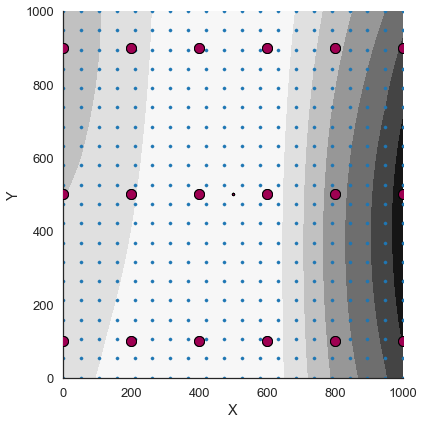

In [6]:
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

grav = tf.reshape(grav,[20,20])
### Plot gravity response
xx,yy = np.meshgrid(X,Y)

gp.plot.plot_data(geo_data, direction='z',)
ax = plt.gca()
ax.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=10,zorder=1)
ax.contourf(xx,yy,grav,zorder=-1)

In [ ]:
TFG.surface_points_all

In [ ]:
interpolator.grid.get_grid_args('centered')[1]

In [ ]:
Z_x = TFG.scalar_field()

In [9]:
surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

with tf.GradientTape() as t:
    TFG = TFGraph(dips_position, dip_angles, azimuth,
      polarity, surface_points_coord, fault_drift,
      grid, values_properties, len_rest_form, Range,
      C_o, nugget_effect_scalar, nugget_effect_grad,
      rescale_factor)
    t.watch(surface_points_coord)
    

    grid_val = TFG.x_to_interpolate(grid)
    weights = TFG.solve_kriging()

    tiled_weights = TFG.extend_dual_kriging(weights, grid_val.shape[0])

    sigma_0_grad = TFG.contribution_gradient_interface(grid_val, tiled_weights)
    sigma_0_interf = TFG.contribution_interface(grid_val, tiled_weights)
    f_0 = TFG.contribution_universal_drift(grid_val,weights)
    Z_x = TFG.scalar_field()
    scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
    formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

    lg_0 = tf.constant(interpolator.grid.get_grid_args('centered')[0])
    lg_1 = tf.constant(interpolator.grid.get_grid_args('centered')[1])
    densities = formations_block[1][lg_0:lg_1]

    grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)
grad = t.gradient(grav,surface_points_coord)
print(grad)

TypeError: x_to_interpolate() missing 2 required positional arguments: 'ref_layer_points' and 'rest_layer_points'

In [ ]:
lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]
densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/Users/zhouji/Documents/github/gempy")

from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import pandas as pd
import gempy as gp
from gempy.assets.geophysics import GravityPreprocessing

def Plot_2D_scaler_field(grid,scaler_field):
    G = grid[np.where(grid[:,1] == [grid[-1][1]])[0]]
    S = scaler_field.numpy()[np.where(grid[:,1] == [grid[0][1]])[0]]
    XX = G[:,0].reshape([50,50])
    ZZ = G[:,2].reshape([50,50])
    S = S.reshape([50,50])
    plt.contour(XX,ZZ,S)


geo_data = gp.create_data([0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_orientations.csv",
                          path_i="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_surface_points.csv")
gp.map_series_to_surfaces(geo_data, {"Strat_Series": (
    'rock2', 'rock1'), "Basement_Series": ('basement')})

geo_data.add_surface_values([2.61,3.1,2.92])

## Gravity test
## ---------
# grav_res = 20
# X = np.linspace(0, 1000, grav_res)
# Y = np.linspace(0, 1000, grav_res)
# Z= 300
# xyz= np.meshgrid(X, Y, Z)
# xy_ravel = np.vstack(list(map(np.ravel, xyz))).T


# geo_data.set_centered_grid(xy_ravel,  resolution = [10, 10, 15], radius=5000)
interpolator = geo_data.interpolator
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']

dips_position, dip_angles, azimuth, polarity, surface_points_coord, fault_drift, grid, values_properties = interpolator.get_python_input_block()[
    0:-3]

# g = GravityPreprocessing(geo_data.grid.centered_grid)
# tz = g.set_tz_kernel()

len_rest_form = interpolator.additional_data.structure_data.df.loc[
    'values', 'len surfaces surface_points']-1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc[
    'values', 'rescaling factor']
nugget_effect_grad = np.cast[dtype](
    np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[interpolator.dtype](
    interpolator.surface_points.df['smooth'])

surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

dips_position = tf.convert_to_tensor(dips_position)
dip_angles = tf.convert_to_tensor(dip_angles)
azimuth = tf.convert_to_tensor(azimuth)
polarity = tf.convert_to_tensor(polarity)
surface_points_coord = tf.convert_to_tensor(surface_points_coord)
fault_drift = tf.convert_to_tensor(fault_drift)
grid = tf.convert_to_tensor(grid)
values_properties = tf.convert_to_tensor(values_properties)
len_rest_form = tf.convert_to_tensor(len_rest_form)
Range = tf.convert_to_tensor(Range,tf.float64)
C_o = tf.convert_to_tensor(C_o)
nugget_effect_grad = tf.convert_to_tensor(nugget_effect_grad)
nugget_effect_scalar = tf.convert_to_tensor(nugget_effect_scalar)
rescale_factor = tf.convert_to_tensor(rescale_factor,tf.float64)
TFG = TFGraph(dips_position, dip_angles, azimuth,
  polarity, surface_points_coord, fault_drift,
  grid, values_properties, len_rest_form, Range,
  C_o, nugget_effect_scalar, nugget_effect_grad,
  rescale_factor)


Z_x = TFG.scalar_field()

Active grids: ['regular']
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing contribution inter
executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing contribution inter
executing sqd
executing sqd
executing sqd
executing sqd


In [8]:
TFG.scalar_field()

executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing contribution inter
executing sqd
executing sqd
executing sqd
executing sqd


<tf.Tensor: shape=(125068,), dtype=float64, numpy=
array([0.3058228 , 0.31166632, 0.31674513, ..., 0.30266602, 0.30266602,
       0.30266602])>

In [ ]:
TFG.ref_layer_points.shape

In [ ]:
TFG.dips_position_all_tiled

In [ ]:
surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

with tf.GradientTape() as t:
    t.watch(TFG.surface_points_all)
    TFG = TFGraph(dips_position, dip_angles, azimuth,
          polarity, surface_points_coord, fault_drift,
          grid, values_properties, len_rest_form, Range,
          C_o, nugget_effect_scalar, nugget_effect_grad,
          rescale_factor)
    
grad = t.gradient(TFG.rest_layer_points,TFG.surface_points_all)

In [ ]:
@tf.function
def gravity():
    TFG = TFGraph(dips_position, dip_angles, azimuth,
      polarity, surface_points_coord, fault_drift,
      grid, values_properties, len_rest_form, Range,
      C_o, nugget_effect_scalar, nugget_effect_grad,
      rescale_factor)
    grid_val = TFG.x_to_interpolate(grid)

In [ ]:
class Pow(tf.Module):
    def __init__(self, exponent):
        super(Pow, self).__init__()
        self.exponent = tf.Variable(exponent, dtype = tf.float32, name='Pow/exponent')
        
    @tf.function
    def function1(self):
        return tf.constant(2.) ** self.exponenate
    
    @tf.function
    def function2(self):
        self.exponenate = self.exponent+1
        return self.function1()*10

In [ ]:
pow = Pow(3)

In [ ]:
pow.function2()

In [ ]:
pow.exponent.assign(4)
pow.function2()

In [ ]:
x_2 = tf.constant([[2,0],[0,3]])

In [ ]:
tf.reshape(x_2[:, 0], [tf.shape(x_2)[0], 1])